In [1]:
#using DataFrames
using Flux
using Flux.Data: DataLoader
using Flux.Optimise: Optimiser, WeightDecay
using Flux: onehotbatch, onecold, logitcrossentropy

import CUDAapi
import CSV
import Images
import ProgressMeter

In [2]:
dataset_path = "..\\..\\data\\10-monkey-species"
train_dir_path = joinpath(dataset_path, "training\\training",)
valid_dir_path = joinpath(dataset_path, "validation\\validation",)
labels_path = "monkey_labels.csv"

"monkey_labels.csv"

# Use CUDA

In [3]:
use_cuda = CUDAapi.has_cuda_gpu()
if use_cuda
    device = gpu
    println("Training on GPU")
else
    device = cpu
    println("Training on CPU")
end

Training on GPU


# Hyper-parameters

In [6]:
η = 1e-4                  # learning rate
λ = 1e-4                  # L2 regularizer param, implemented as weight decay
epochs = 40               # number of epochs
batchsize = 32            # batch size
input_shape = (96, 96, 3) # input shape for model
aug_multiple = 3          # data augmentation

3

# Load Dataset

- labels

In [68]:
df_labels = CSV.read(labels_path)

,Label,LatinName,CommonName
,String,String,String
1,n0,alouatta_palliata,mantled_howler
2,n1,erythrocebus_patas,patas_monkey
3,n2,cacajao_calvus,bald_uakari
4,n3,macaca_fuscata,japanese_macaque
5,n4,cebuella_pygmea,pygmy_marmoset
6,n5,cebus_capucinus,white_headed_capuchin
7,n6,mico_argentatus,silvery_marmoset
8,n7,saimiri_sciureus,common_squirrel_monkey
9,n8,aotus_nigriceps,black_headed_night_monkey


- train/test dataset

In [4]:
using Augmentor

pl = FlipX(0.5) |> Resize(128, 128) |> Rotate([-10,-3,0,3,10]) |> CropSize(96,96) |> Zoom(0.8:0.1:1.2)

5-step Augmentor.ImmutablePipeline:
 1.) Either: (50%) Flip the X axis. (50%) No operation.
 2.) Resize to 128×128
 3.) Rotate by θ ∈ [-10, -3, 0, 3, 10] degree
 4.) Crop a 96×96 window around the center
 5.) Zoom by I ∈ {0.8×0.8, 0.9×0.9, 1.0×1.0, 1.1×1.1, 1.2×1.2}

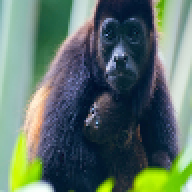

In [16]:
import Images

function readImageArray(;path, input_size, aug)
    img = Images.load(path)
    if aug
        img = augment(img, pl)
    end
    img = permutedims(Images.channelview(img), (2,3,1))
    img = Images.imresize(img, input_size)
    return img
end

path = "..\\..\\data\\10-monkey-species\\validation\\validation\\n0\\n000.jpg"
img = readImageArray(path=path, input_size=input_shape[1:2], aug=true)
Images.colorview(Images.RGB, Images.channelview(permutedims(img, (3,1,2))))

In [71]:
function getDataLoader(;dir_path, shuffle, aug_multiple)
    sample_imgs = []
    sample_anns  = []
    for index_species in readdir(dir_path)
        path_dir_species = joinpath(dir_path, index_species)
        for filename in readdir(path_dir_species)
            path_file = joinpath(path_dir_species, filename)
            append!(sample_imgs, [readImageArray(path=path_file, input_size=input_shape[1:2], aug=false)])
            append!(sample_anns, [onecold((df_labels.Label .== index_species), 0:9)])
            if aug_multiple > 0
                for i in 1:aug_multiple
                    append!(sample_imgs, [readImageArray(path=path_file, input_size=input_shape[1:2], aug=true)])
                    append!(sample_anns, [onecold((df_labels.Label .== index_species), 0:9)])
                end
            end
        end
    end

    x = [img for img in sample_imgs]
    x = cat(x...; dims=4)        
    x = Array{Float32}(x)
    y = onehotbatch(sample_anns, 0:9)
    return DataLoader(x, y,  batchsize=batchsize, shuffle=shuffle)
end

dataset_path = "..\\..\\data\\10-monkey-species"
train_dir_path = joinpath(dataset_path, "training\\training",)
valid_dir_path = joinpath(dataset_path, "validation\\validation",)

train_loader = getDataLoader(dir_path=train_dir_path, shuffle=true, aug_multiple=aug_multiple)
test_loader  = getDataLoader(dir_path=valid_dir_path, shuffle=false, aug_multiple=0)

getDataLoader (generic function with 1 method)

# Build CNNs

In [61]:
# write your model here
num_params(model) = sum(length, Flux.params(model))

# function buildModel(;input_shape)
#     return Chain(
#         x -> reshape(x, input_shape..., :),
#         Conv((5, 5), 3=>16, stride=2),
#         BatchNorm(16, relu),
#         Conv((3, 3), 16=>32, stride=2),
#         BatchNorm(32, relu),
#         Conv((3, 3), 32=>64, stride=2),
#         BatchNorm(64, relu),
#         Conv((1, 1), 64=>64, stride=1),
#         BatchNorm(64, relu),
#         Conv((3, 3), 64=>128, stride=2),
#         BatchNorm(128, relu),
#         Conv((1, 1), 128=>128, stride=1),
#         BatchNorm(128, relu),
#         GlobalMeanPool(),
#         flatten,
#         Dropout(0.25),
#         Dense(128, 64),
#         Dropout(0.25),
#         Dense(64, 10),
#         softmax
#     )
# end

function buildModel(;input_shape)
    return Chain(
        x -> reshape(x, input_shape..., :),
        Conv((5, 5), 3=>24, stride=2),
        BatchNorm(24, relu),
        Conv((3, 3), 24=>48, stride=2),
        BatchNorm(48, relu),
        Conv((3, 3), 48=>64, stride=2),
        BatchNorm(64, relu),
        Conv((1, 1), 64=>64, stride=1),
        BatchNorm(64, relu),
        Conv((3, 3), 64=>128, stride=2),
        BatchNorm(128, relu),
        Conv((1, 1), 128=>128, stride=1),
        BatchNorm(128, relu),
        GlobalMeanPool(),
        flatten,
        Dropout(0.25),
        Dense(128, 64),
        Dropout(0.25),
        Dense(64, 10),
        softmax
    )
end

model = buildModel(input_shape=input_shape) |> device;
println("CNNs model: $(num_params(model)) trainable params");

CNNs model: 144298 trainable params


In [62]:
fake_input = randn(input_shape) |> device
fake_output = model(fake_input)
size(fake_output)

(10, 1)

# Loss function

In [63]:
loss(ŷ, y) = logitcrossentropy(ŷ, y)

round4(x) = round(x, digits=4)

function calc_loss_accuracy(loader, model, device)
    l = 0f0
    acc = 0
    ntot = 0
    for (x, y) in loader
        x, y = x |> device, y |> device
        ŷ = model(x)
        l += loss(ŷ, y) * size(x)[end]        
        acc += sum(onecold(ŷ |> cpu) .== onecold(y |> cpu))
        ntot += size(x)[end]
    end
    return (loss = l/ntot |> round4, acc = acc/ntot*100 |> round4)
end

calc_loss_accuracy (generic function with 1 method)

# Callback function

In [64]:
# callback function
function callback(epoch)
    train = calc_loss_accuracy(train_loader, model, device)
    test = calc_loss_accuracy(test_loader, model, device)        
    println("Epoch: $epoch   Train: $(train)   Test: $(test)")
end

callback (generic function with 1 method)

# Training

In [65]:
# define optimizer
opt = ADAM(η) 
if λ > 0 
    opt = Optimiser(opt, WeightDecay(λ))
end

Optimiser(Any[ADAM(0.0001, (0.9, 0.999), IdDict{Any,Any}()), WeightDecay(0.0001)])

In [66]:
params_model = Flux.params(model)

println("Starting Training")
callback(0)

for epoch in 1:epochs
    progress = ProgressMeter.Progress(length(train_loader))
    
    # update parameters
    for (x, y) in train_loader
        x = x |> device
        y = y |> device
        grads_model = Flux.gradient(params_model) do
            ŷ = model(x)
            loss(ŷ, y)
        end
        Flux.Optimise.update!(opt, params_model, grads_model)
        ProgressMeter.next!(progress)   # comment out for no progress bar
    end
    
    #  logging
    if epoch % 5 == 0
        callback(epoch)
    end
end

Starting Training
Epoch: 0   Train: (loss = 2.3026f0, acc = 10.2687)   Test: (loss = 2.3026f0, acc = 9.9265)

Progress:   1%|█                                        |  ETA: 0:00:46

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


Epoch: 5   Train: (loss = 2.0142f0, acc = 45.0592)   Test: (loss = 2.0666f0, acc = 41.5441)

Progress:   3%|██                                       |  ETA: 0:00:04

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


Epoch: 10   Train: (loss = 1.9039f0, acc = 58.9481)   Test: (loss = 2.0191f0, acc = 44.8529)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


Epoch: 15   Train: (loss = 1.8318f0, acc = 65.7787)   Test: (loss = 1.9918f0, acc = 47.7941)

Progress:   4%|██                                       |  ETA: 0:00:03

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


Epoch: 20   Train: (loss = 1.7668f0, acc = 75.9791)   Test: (loss = 1.9464f0, acc = 54.7794)

Progress:   4%|██                                       |  ETA: 0:00:03

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


Epoch: 25   Train: (loss = 1.6735f0, acc = 85.4053)   Test: (loss = 1.8959f0, acc = 60.2941)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


Epoch: 30   Train: (loss = 1.6439f0, acc = 87.5911)   Test: (loss = 1.8914f0, acc = 60.6618)

Progress:   4%|██                                       |  ETA: 0:00:03

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


Epoch: 35   Train: (loss = 1.6777f0, acc = 82.8552)   Test: (loss = 1.9001f0, acc = 61.0294)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


Epoch: 40   Train: (loss = 1.5869f0, acc = 91.5528)   Test: (loss = 1.849f0, acc = 65.0735)


# Evaluation

In [72]:
test = calc_loss_accuracy(test_loader, model, device)        
println("Test: $(test)")

Test: (loss = 1.849f0, acc = 65.0735)
